In [2]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import pymysql
from datetime import datetime
import mysql.connector
from sqlalchemy import create_engine
from tqdm import tqdm
from pandas.tseries.offsets import MonthEnd

In [3]:
def get_adata_quarter(adata, data_name):

    data = adata.pivot_table(index='date', columns='permno', values= data_name).astype('float')
    # data = data.fillna(method='ffill', limit=2)
    data = data.loc[[x for x in data.index if x.month % 3 == 2]].reindex(data.index).ffill(limit=2).dropna(how='all')

    return data

def which_quantile(data_scalar, nyse_criteria_list):
  if np.isinf(data_scalar):
    return np.nan

  for q in range(1, len(nyse_criteria_list) - 1):
    if nyse_criteria_list[q-1] <= data_scalar < nyse_criteria_list[q]:
      return q

  return len(nyse_criteria_list) - 1


def get_quantile(data_series, nyse_bool, q):
    # NaN 값 처리
    data_series = data_series.dropna()

    if len(data_series) == 0:
        return np.nan

    # nyse_bool에서 NaN 값을 False로 변환
    tmp_nyse_bool = nyse_bool.loc[data_series.name].fillna(False)
    nyse_data_series = data_series[tmp_nyse_bool]

    nyse_criteria = [np.nanpercentile(nyse_data_series, x) for x in range(0, 100+int(100/q), int(100/q))]

    return data_series.apply(lambda x: which_quantile(x, nyse_criteria))

def get_port_rtn(ret_df, wl1_df):
  return (ret_df * wl1_df).sum(axis=1).replace(0, np.nan).dropna()


def get_quantile_rtn(ret_df, me_df, quantile_df):
  q = np.unique(quantile_df.values.flatten())
  q = int(max(q[~np.isnan(q)]))

  port_rtn = pd.DataFrame(index=ret_df.index, columns=range(1, q+1), dtype=float)

  for i in range(1, q+1):
    tmp_me = me_df[quantile_df == i]
    tmp_wl1 = tmp_me.divide(tmp_me.sum(axis=1), axis=0).shift(1).dropna(how='all')

    port_rtn[i] = get_port_rtn(ret_df, tmp_wl1)

  port_rtn[f'{q}-1'] = port_rtn[q] - port_rtn[1]
  return port_rtn.dropna(how='all')

def calculate_annual_volatility_and_sharpe_ratio(df, risk_free_rate=0.02):
    """
    월간 수익률 데이터프레임에서 연간 변동성과 샤프 비율을 계산합니다.

    :param df: 월간 수익률이 포함된 데이터프레임. 인덱스는 날짜, 컬럼은 'returns'.
    :param risk_free_rate: 연간 무위험 수익률 (기본값: 0.02)
    :return: 연간 변동성과 샤프 비율
    """
    # 연간 수익률 계산
    cumulative_returns = (1 + df['returns']).prod() ** (12 / len(df)) - 1

    # 연간 변동성 계산
    annual_volatility = df['returns'].std() * np.sqrt(12)

    # 샤프 비율 계산
    sharpe_ratio = (cumulative_returns - risk_free_rate) / annual_volatility

    return annual_volatility, sharpe_ratio

In [4]:
today_dt = datetime.today().strftime("%Y%m%d")
print(today_dt)

20250522


In [5]:
path = r"C:\Users\MetaM\Downloads\qdata_2025-05-22.csv"

In [ ]:
us_data_path_q = path 

fundq = pd.read_csv(us_data_path_q)
fundq['date'] = pd.to_datetime(fundq['date']) + MonthEnd(0)
qdata = fundq.drop(columns=['Unnamed: 0'])

qdata_re = qdata.ffill(limit=2)
qdata_re = qdata_re.ffill(limit=1)

processed_qdata = qdata_re.replace({pd.NA: None, pd.NaT: None, float('nan'): None})
processed_qdata_sample = processed_qdata.iloc[:]

# MySQL 연결 정보 설정
host_num = 'hystox74.synology.me'
cnx = pymysql.connect(
    host=host_num,
    port=3307,
    user='stox7412',
    passwd='Apt106503!~',
    db='investar',
    autocommit=True
)
cursor = cnx.cursor()

# 데이터프레임 컬럼 이름 확인
# print("데이터프레임 컬럼 개수:", len(processed_qdata_sample.columns))
# print("데이터프레임 컬럼:", processed_qdata_sample.columns)

# 테이블 생성 (필요할 경우)
cursor.execute('''
    CREATE TABLE IF NOT EXISTS US_qdata (
        permno INT,
        edate DATE,
        date DATE,
        dlret FLOAT,
        dlretx FLOAT,
        exchcd INT,
        naics INT,
        permco INT,
        prc FLOAT,
        ret FLOAT,
        shrcd INT,
        shrout BIGINT,
        siccd INT,
        ticker VARCHAR(10),
        cusip VARCHAR(10),
        rankyear INT,
        retadj FLOAT,
        me FLOAT,
        adj_close FLOAT,
        gvkey FLOAT,
        tic VARCHAR(10),
        actq FLOAT, aoq FLOAT, apq FLOAT, atq FLOAT,
        ceqq FLOAT, cheq FLOAT, cogsq FLOAT, dlcq FLOAT, dpq FLOAT,
        epspiq FLOAT, ibq FLOAT, icaptq FLOAT, intanq FLOAT, invtq FLOAT,
        ivaoq FLOAT, ivstq FLOAT, lctq FLOAT, loq FLOAT, ltq FLOAT,
        mibtq FLOAT, niq FLOAT, piq FLOAT, ppegtq FLOAT, ppentq FLOAT,
        pstkrq FLOAT, recdq FLOAT, rectq FLOAT, rectrq FLOAT, saleq FLOAT,
        seqq FLOAT, txdiq FLOAT, txpq FLOAT, txtq FLOAT, xidoq FLOAT,
        xintq FLOAT, xrdq FLOAT, xsgaq FLOAT, capxy FLOAT, chechy FLOAT,
        dlcchy FLOAT, dltisy FLOAT, fincfy FLOAT, oancfy FLOAT,
        prstkcy FLOAT, sstky FLOAT,
        PRIMARY KEY (date, permno)
    )
''')

# 데이터 삽입 (중복 방지)
for index, row in tqdm(processed_qdata_sample.iterrows(), total=len(processed_qdata_sample)):
    try:
        cursor.execute('''
            INSERT IGNORE INTO US_qdata (
                permno, edate, date, dlret, dlretx, exchcd, naics, permco, prc, ret,
                shrcd, shrout, siccd, ticker, cusip, rankyear, retadj, me, adj_close, gvkey,
                tic, actq, aoq, apq, atq, ceqq, cheq, cogsq, dlcq, dpq,
                epspiq, ibq, icaptq, intanq, invtq, ivaoq, ivstq, lctq, loq, ltq,
                mibtq, niq, piq, ppegtq, ppentq, pstkrq, recdq, rectq, rectrq, saleq,
                seqq, txdiq, txpq, txtq, xidoq, xintq, xrdq, xsgaq, capxy, chechy,
                dlcchy, dltisy, fincfy, oancfy, prstkcy, sstky
            )
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s,
                    %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s,
                    %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s,
                    %s, %s, %s, %s, %s, %s
            )
        ''', tuple(row))
    except Exception as e:
        print(f"Error at row {index}: {e}")

# 커밋 및 연결 종료
cnx.commit()
cursor.close()
cnx.close()



In [25]:
fundq[fundq['permno'] == 64311].tail(12)

,Unnamed: 0,permno,edate,date,dlret,dlretx,exchcd,naics,permco,prc,...,xrdq,xsgaq,capxy,chechy,dlcchy,dltisy,fincfy,oancfy,prstkcy,sstky
886354,886354,64311.0,2024-02-29,2024-02-29,NaN,NaN,1.0,488510.0,21294.0,253.380005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886355,886355,64311.0,2024-03-31,2024-03-31,NaN,NaN,1.0,488510.0,21294.0,254.869995,...,NaN,NaN,2199.0,-916.0,NaN,400.0,89.0,839.0,6.0,NaN
886356,886356,64311.0,2024-04-30,2024-04-30,NaN,NaN,1.0,488510.0,21294.0,230.320007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886357,886357,64311.0,2024-05-31,2024-05-31,NaN,NaN,1.0,488510.0,21294.0,224.800003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886358,886358,64311.0,2024-06-30,2024-06-30,NaN,NaN,1.0,488510.0,21294.0,214.690002,...,NaN,NaN,2768.0,-909.0,NaN,600.0,-217.0,1875.0,5.0,NaN
886359,886359,64311.0,2024-07-31,2024-07-31,NaN,NaN,1.0,488510.0,21294.0,249.559998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886360,886360,64311.0,2024-08-31,2024-08-31,NaN,NaN,1.0,488510.0,21294.0,256.160004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886361,886361,64311.0,2024-09-30,2024-09-30,NaN,NaN,1.0,488510.0,21294.0,248.500000,...,NaN,NaN,3349.0,-593.0,NaN,1051.0,-903.0,3101.0,NaN,15.0
886362,886362,64311.0,2024-10-31,2024-10-31,NaN,NaN,1.0,488510.0,21294.0,250.429993,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886363,886363,64311.0,2024-11-30,2024-11-30,NaN,NaN,1.0,488510.0,21294.0,275.850006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# MySQL 연결 정보 설정
host_num = 'hystox74.synology.me'
cnx = pymysql.connect(
    host=host_num,
    port=3307,
    user='stox7412',
    passwd='Apt106503!~',
    db='investar',
    autocommit=True
)
cursor = cnx.cursor()

# SQL 쿼리: 2005년 1월 1일 이후의 데이터 추출
query = '''
    SELECT *
    FROM US_qdata
    WHERE date >= '2006-01-01'
'''

# SQL 쿼리 실행 및 데이터프레임으로 변환
df = pd.read_sql(query, cnx)

# MySQL 연결 종료
cnx.close()

C:\Users\MetaM\AppData\Local\Temp\ipykernel_8136\1121214757.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnx)


In [9]:
qdata = df
qdata['permno'] = qdata['permno'].astype('int')

# qdata = qdata.ffill(limit=2)
#
qdata['siccd'] = qdata['siccd'].apply(lambda x: np.nan if np.isnan(x) else int(x))
#

# 한국, 미국데이터 공통 전처리

util_and_fin = list(range(4900, 4950)) + list(range(6000, 7000)) # 유틸리티, 금융업 제외 (한국은 금융업만 제외)
qdata = qdata[~qdata['siccd'].isin(util_and_fin)]

permno_list = sorted(list(set(qdata['permno'])))
print(len(permno_list))

qdata = qdata[qdata['permno'].isin(permno_list)]

qdata = qdata[qdata['naics'] != 522110]


8240


In [10]:
#Income statement
sale = get_adata_quarter(qdata, 'saleq').shift(1)
cogs = get_adata_quarter(qdata, 'cogsq').shift(1)
gp = sale - cogs
xsga = get_adata_quarter(qdata, 'xsgaq').shift(1)
xrd = get_adata_quarter(qdata, 'xrdq').shift(1)
xint = get_adata_quarter(qdata, 'xintq').shift(1)
op = get_adata_quarter(qdata, 'xintq').shift(1)
pi = get_adata_quarter(qdata, 'piq').shift(1)     # pretax income
tax = get_adata_quarter(qdata, 'txtq').shift(1)   # income tax
xido = get_adata_quarter(qdata, 'xidoq').shift(1) # extraordinary item and discontinue
ni = get_adata_quarter(qdata, 'ibq').shift(1)
nix = get_adata_quarter(qdata, 'niq').shift(1)
fi = nix + xint.replace(np.nan, 0).shift(1)

#Cash flow statement
capx = get_adata_quarter(qdata, 'capxy').shift(1)                          # capex
capex_sale = capx.divide(sale.replace(0, np.nan), axis=0).shift(1)
ocf = get_adata_quarter(qdata, 'oancfy').shift(1)
fcf = ocf - capx
eqbb = get_adata_quarter(qdata, 'prstkcy').shift(1)                        # 자사주 매입
eqis = get_adata_quarter(qdata, 'sstky').shift(1)                          # 자사주 매각
eqnetis = eqis.replace(np.nan, 0) - eqbb.replace(np.nan, 0).shift(1)

dltnetis = get_adata_quarter(qdata, 'dltisy').shift(1)                 # 장기채권 발행
dstnetis = get_adata_quarter(qdata, 'dlcchy').shift(1)                 # 유동채권 변화
dbnetis = dltnetis - dstnetis
netis = eqnetis.replace(np.nan, 0) + dbnetis.replace(np.nan, 0)

# Balance Sheet - Assets
at = get_adata_quarter(qdata, 'atq').shift(1)      # 분기 자산
at = at[at > 0]
ca = get_adata_quarter(qdata, 'actq').shift(1)     # 분기 유동자산
rec = get_adata_quarter(qdata, 'rectq').shift(1)   # receivables
cash = get_adata_quarter(qdata, 'cheq').shift(1)   # 현금
inv = get_adata_quarter(qdata, 'invtq').shift(1)   # inventory
nca = at - ca
intan = get_adata_quarter(qdata, 'intanq').shift(1) #무형자산
ivao = get_adata_quarter(qdata, 'ivaoq').shift(1)   # investment
ppeg = get_adata_quarter(qdata, 'ppegtq').shift(1)  # porperty plant and Equipment total
ppen = get_adata_quarter(qdata, 'ppentq').shift(1)  # porperty plant and Equipment net

# #Balance Sheet - Liabilities
lt = get_adata_quarter(qdata, 'ltq').shift(1)       # 총부채
cl = get_adata_quarter(qdata, 'lctq').shift(1)      # 유동부채
ap = get_adata_quarter(qdata, 'atq').shift(1)       # asset total
debtst = get_adata_quarter(qdata, 'dlcq').shift(1)  # Debt in current liability
txp = get_adata_quarter(qdata, 'txpq').shift(1)     # Income taxes payable
ncl = lt - cl
debtlt = get_adata_quarter(qdata, 'dltisy').shift(1) # long term debt total
txditc = get_adata_quarter(qdata, 'txdiq').shift(1)  #  Income Taxes - Deferred (txdiq)

# #Balance Sheet - Financing
pstk = get_adata_quarter(qdata, 'pstkrq').shift(1)   # 상환우선주
debt = (debtst.replace(np.nan, 0) + debtlt.replace(np.nan, 0)).replace(0, np.nan)
netdebt = debt - cash.replace(np.nan, 0)
seq = get_adata_quarter(qdata, 'seqq').shift(1)  # share holder equity
ceq = get_adata_quarter(qdata, 'ceqq').shift(1)  # common equit

me =  get_adata_quarter(qdata, 'me').shift(1)

icapt = get_adata_quarter(qdata, 'icaptq').shift(1)  # invested capital
mib = get_adata_quarter(qdata, 'mibtq').shift(1)     # Noncontrolling Interests - Total - Balance Sheet (mibtq)
bev = icapt + debtst.replace(np.nan, 0) - cash.replace(np.nan, 0)
bev = bev[bev > 0]
#
#Balance Sheet - Summary
nwc = ca - cl
coa = ca - cash
col = cl - debtst.replace(np.nan, 0)
cowc = coa - col
ncoa = at - ca - ivao
ncol = lt - cl - debtlt
nncoa = ncoa - ncol

oa = coa + ncoa
ol = col + ncol
ao = get_adata_quarter(qdata, 'aoq').shift(1)      #  asset other
lo = get_adata_quarter(qdata, 'loq').shift(1)      # liabilities other
dp = get_adata_quarter(qdata, 'dpq').shift(1)
noa = oa - ol
lnoa = ppen + intan + ao - lo + dp
aliq = cash + 0.75*coa + 0.5*(at - ca - intan.replace(np.nan, 0))

be = at - lt
be = be[be > 0]

roeq = ni.divide(be.replace(0, np.nan), axis=0)
roaq = ni.divide(at.replace(0, np.nan), axis=0)

#Market based
oacc = ni - ocf

mev = me + netdebt
mev = mev[mev > 0]
mev_jun = mev.loc[[x for x in mev.index if x.month == 6]].reindex(mev.index).ffill(limit=11).dropna(how='all')

#Accounting Characteristics

##Accounting based size measures
assets = at
sales = sale
book_equity = be
net_income = ni
enterprise_value = mev
mat = at + be + me

<Axes: xlabel='date'>

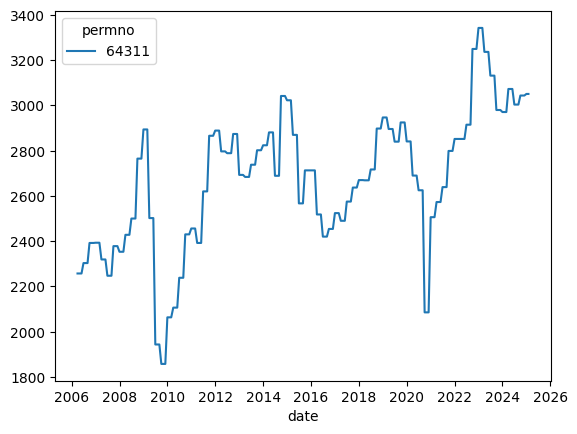

In [12]:
def get_unique_values(df, ticker_name):
    unique_values = df[df['ticker'] == ticker_name]['permno'].unique() # unique 값 추출
    return unique_values.tolist()  # 리스트로 변환

permno_number = get_unique_values(qdata, 'NSC')

sale[permno_number].plot()

In [23]:
permno_number

[64311]

In [21]:
qdata[qdata['ticker'] == 'AAPL'][['date','saleq']].tail(12)

,date,saleq
869091,2024-02-29,119575.0
874279,2024-03-31,90753.0
879391,2024-04-30,90753.0
883963,2024-05-31,90753.0
888530,2024-06-30,85777.0
893079,2024-07-31,85777.0
897610,2024-08-31,85777.0
902122,2024-09-30,85777.0
906625,2024-10-31,94930.0
911065,2024-11-30,94930.0


In [15]:
sale

permno,0,10019,10025,10026,10028,10032,10042,10044,10051,10066,...,93422,93423,93426,93428,93429,93430,93432,93433,93434,93436
date,,,,,,,,,,,,,,,,,,,,,
2006-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-31,NaN,NaN,192.760,108.571,14.907,328.306,1.086,8.126,149.194,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-04-30,NaN,NaN,192.760,108.571,14.907,328.306,1.086,8.126,149.194,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-05-31,NaN,NaN,192.760,108.571,14.907,328.306,1.086,8.126,149.194,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-30,NaN,NaN,193.251,112.044,9.721,337.911,0.593,6.768,140.445,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30,0.543,NaN,NaN,439.957,45.297,960.751,NaN,6.407,NaN,6.117,...,NaN,NaN,77.359,NaN,NaN,NaN,NaN,NaN,NaN,25500.0
2024-10-31,0.543,NaN,NaN,439.957,45.297,960.751,NaN,6.407,NaN,6.117,...,NaN,NaN,77.359,NaN,NaN,NaN,NaN,NaN,NaN,25500.0
2024-11-30,0.543,NaN,NaN,439.957,45.297,960.751,NaN,6.407,NaN,6.117,...,NaN,NaN,77.359,NaN,NaN,NaN,NaN,NaN,NaN,25500.0


In [32]:
sale[permno_number].tail(12)

permno,14593
date,
2023-10-31,81797.0
2023-11-30,81797.0
2023-12-31,89498.0
2024-01-31,89498.0
2024-02-29,89498.0
2024-03-31,119575.0
2024-04-30,119575.0
2024-05-31,119575.0
2024-06-30,90753.0


In [34]:
qdata[qdata['ticker'] == 'AAPL']

,permno,edate,date,dlret,dlretx,exchcd,naics,permco,prc,ret,...,xrdq,xsgaq,capxy,chechy,dlcchy,dltisy,fincfy,oancfy,prstkcy,sstky
224,14593,2006-01-31,2006-01-31,NaN,NaN,3,334111.0,7,75.51,0.050355,...,182.0,814.0,82.0,659.0,0.0,0.0,283.0,283.0,0.0,134.0
3895,14593,2006-02-28,2006-02-28,NaN,NaN,3,334111.0,7,68.49,-0.092968,...,182.0,814.0,82.0,659.0,0.0,0.0,283.0,283.0,0.0,134.0
7560,14593,2006-03-31,2006-03-31,NaN,NaN,3,334111.0,7,62.72,-0.084246,...,176.0,768.0,275.0,2855.0,0.0,0.0,142.0,158.0,353.0,212.0
11215,14593,2006-04-30,2006-04-30,NaN,NaN,3,334111.0,7,70.39,0.122290,...,176.0,768.0,275.0,2855.0,0.0,0.0,142.0,158.0,353.0,212.0
14867,14593,2006-05-31,2006-05-31,NaN,NaN,3,334111.0,7,59.77,-0.150874,...,176.0,768.0,275.0,2855.0,0.0,0.0,142.0,158.0,353.0,212.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702238,14593,2024-05-31,2024-05-31,NaN,NaN,3,334220.0,7,192.25,0.130222,...,7903.0,14371.0,4388.0,3184.0,-3982.0,0.0,-61018.0,62585.0,46219.0,NaN
705276,14593,2024-06-30,2024-06-30,NaN,NaN,3,334220.0,7,210.62,0.095553,...,8006.0,14326.0,6539.0,-4102.0,-2985.0,0.0,-97035.0,91443.0,75029.0,NaN
708315,14593,2024-07-31,2024-07-31,NaN,NaN,3,334220.0,7,222.08,0.054411,...,8006.0,14326.0,6539.0,-4102.0,-2985.0,0.0,-97035.0,91443.0,75029.0,NaN
711361,14593,2024-08-31,2024-08-31,NaN,NaN,3,334220.0,7,229.00,0.032354,...,8006.0,14326.0,6539.0,-4102.0,-2985.0,0.0,-97035.0,91443.0,75029.0,NaN
